# Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**

In [139]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [119]:
def entropy_func(class_count: Counter, num_samples: int) -> float:
    return -sum([(count / num_samples) * math.log(count / num_samples, 2) for count in class_count.values()])

class Group:
    def __init__(self, group_classes: np.ndarray):
        self.group_classes: np.ndarray = group_classes
        self.entropy: float = self.group_entropy()

    def __len__(self) -> int:
        return self.group_classes.size

    def group_entropy(self) -> float:
        return entropy_func(Counter(self.group_classes), len(self.group_classes))


class Node:
    def __init__(self, split_feature: int, split_val: float, depth=None, child_node_a=None, child_node_b=None, val=None):
        self.split_feature: int = split_feature
        self.split_val: float = split_val
        self.depth: int = depth
        self.child_node_a: Node = child_node_a
        self.child_node_b: Node = child_node_b
        self.val: int = val

    def predict(self, data: np.ndarray):
        if self.is_leaf():
            return self.val
        if data[self.split_feature] <= self.split_val:
            return self.child_node_a.predict(data)
        else:
            return self.child_node_b.predict(data)
        

    def is_leaf(self):
        return self.val is not None


class DecisionTreeClassifier(object):
    def __init__(self, max_depth: int):
        self.depth: int = 0
        self.max_depth: int = max_depth
        self.tree: Node = None

    @staticmethod
    def get_split_entropy(group_a: Group, group_b: Group) -> float:
        """
        Calculates the split entropy of two groups
        Returns the split entropy
        """
        total = len(group_a) + len(group_b)
        return (len(group_a) / total) * group_a.entropy +  (len(group_b) / total) * group_b.entropy

    def get_information_gain(self, parent_group: Group, child_group_a: Group, child_group_b: Group) -> float:
        """
        Calculates the information gain of a split
        Returns the information gain
        """
        return parent_group.entropy - self.get_split_entropy(child_group_a, child_group_b)

    def get_best_feature_split(self, feature_values: np.ndarray, classes: np.ndarray) -> (int, float):
        """
        Calculates the best split for a feature
        Returns the split value and the information gain
        """
        distinct_values = np.sort(np.unique(feature_values))
        best_split = None   # (split_val, info_gain)
        for value in distinct_values:
            group_a_values = [classes[i] for i, v in enumerate(feature_values) if v <= value ]
            group_a = Group(np.array(group_a_values))

            group_b_values = [classes[i] for i, v in enumerate(feature_values) if v > value ]
            group_b = Group(np.array(group_b_values))

            info_gain = self.get_information_gain(Group(classes), group_a, group_b)

            if best_split is None or info_gain > best_split[1]:
                best_split = (value, info_gain)
        
        return best_split
            
    def get_best_split(self, data: np.ndarray, classes: np.ndarray) -> (int, float, float): 
        """
        Calculates the best split for a dataset
        Returns the feature index, split value and the information gain
        """
        _, cols = data.shape
        best_split = None   # (feature, split_val, info_gain)
        for feature in range(cols):
            split_val, info_gain = self.get_best_feature_split(data[:, feature], classes)

            if best_split is None or info_gain > best_split[2]:
                best_split = (feature, split_val, info_gain)
    
        return best_split

    def build_tree(self, data: np.ndarray, classes: np.ndarray, depth=0):
        def get_tree(data: np.ndarray, classes: np.ndarray, depth) -> Node:
            feature, split_val, info_gain = self.get_best_split(data, classes)
            if depth == self.max_depth or len(np.unique(classes)) == 1:
                return Node(None, None, depth, val = Counter(classes).most_common(1)[0][0])
            
            child_a_data, child_a_classes = zip(*[(data[i], classes[i]) for i, v in enumerate(data[:, feature]) if v <= split_val ])
            child_b_data, child_b_classes = zip(*[(data[i], classes[i]) for i, v in enumerate(data[:, feature]) if v > split_val ])

            child_a = get_tree(np.array(child_a_data), np.array(child_a_classes), depth + 1)
            child_b = get_tree(np.array(child_b_data), np.array(child_b_classes), depth + 1)

            return Node(feature, split_val, depth, child_node_a=child_a, child_node_b=child_b)
        
        self.tree = get_tree(data, classes, depth)

    def predict(self, data):
        return self.tree.predict(data)

In [145]:
max_depth = 3
test_size = 0.2
random_state = 42


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

dc = DecisionTreeClassifier(max_depth)
dc.build_tree(x_train, y_train)

predictions: [(int, int)] = []  # (prediction, ground_truth)
for sample, gt in zip(x_test, y_test):
    prediction = dc.predict(sample)
    predictions.append((prediction, gt))
    print(f"Prediction: {prediction}, Ground Truth: {gt}")

accuracy = sum([1 for p in predictions if p[0] == p[1]]) / len(predictions)
print(f"Accuracy: {accuracy}")

Prediction: 1, Ground Truth: 1
Prediction: 0, Ground Truth: 0
Prediction: 2, Ground Truth: 2
Prediction: 1, Ground Truth: 1
Prediction: 2, Ground Truth: 1
Prediction: 0, Ground Truth: 0
Prediction: 1, Ground Truth: 1
Prediction: 2, Ground Truth: 2
Prediction: 1, Ground Truth: 1
Prediction: 1, Ground Truth: 1
Prediction: 2, Ground Truth: 2
Prediction: 0, Ground Truth: 0
Prediction: 0, Ground Truth: 0
Prediction: 0, Ground Truth: 0
Prediction: 0, Ground Truth: 0
Prediction: 1, Ground Truth: 1
Prediction: 2, Ground Truth: 2
Prediction: 1, Ground Truth: 1
Prediction: 1, Ground Truth: 1
Prediction: 2, Ground Truth: 2
Prediction: 0, Ground Truth: 0
Prediction: 2, Ground Truth: 2
Prediction: 0, Ground Truth: 0
Prediction: 2, Ground Truth: 2
Prediction: 2, Ground Truth: 2
Prediction: 2, Ground Truth: 2
Prediction: 2, Ground Truth: 2
Prediction: 2, Ground Truth: 2
Prediction: 0, Ground Truth: 0
Prediction: 0, Ground Truth: 0
Accuracy: 0.9666666666666667


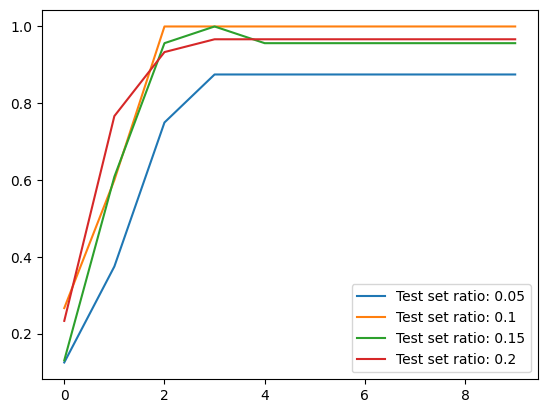

In [137]:
# Accuracy per depth

fig, ax = plt.subplots()

depths = range(10)
test_sizes = [0.05, 0.1, 0.15, 0.2]

for test_size in test_sizes:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=None)
    accuracies = []
    for depth in depths:
        classifier = DecisionTreeClassifier(depth)
        classifier.build_tree(x_train, y_train)

        predictions = [(classifier.predict(sample), gt) for sample, gt in zip(x_test, y_test)]  # (prediction, ground_truth)
        accuracy = sum([1 for p in predictions if p[0] == p[1]]) / len(predictions)

        accuracies.append(accuracy)

    ax.plot(depths, accuracies, label=f"Test set ratio: {test_size}")

plt.legend()
plt.show()
